# <span style="color:purple">TAQ Project in Python</span>

In this project, we'll use the __NYSE Trade and Quote (TAQ)__ database on WRDS described here: https://wrds-www.wharton.upenn.edu/pages/about/data-vendors/nyse-trade-and-quote-taq/.  This is our workflow:

1. Select a company and a trading date. Fetch stock price data for this company by the second.
2. Obtain the five-minute average stock price for each observation (not a rolling average) as a new table.
3. Merge the two tables.
4. Graph the time series for the stock prices with the five-minute average indicated by blue dots.

To get started, we'll first load our python libraries and then establish a WRDS connection.

In [2]:
# import packages
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [3]:
# wrds connection
conn = wrds.Connection(wrds_username='best-user-ever')

Loading library list...
Done


### <span style="color:purple">1. Obtain WRDS data table</span>

Select a company and date to use in this example. 

In [12]:
# inputs for a date and ticker
dd = '20230622'
stock = "AAPL"

Submit a sql query.

In [13]:
# Create the SQL query to get a table from the TAQ database
sql = f"""
SELECT CONCAT(date, ' ', time_m) AS DT,
       ex, sym_root, sym_suffix, price, size, tr_scond
FROM taqmsec.ctm_{dd}
WHERE (ex = 'N' OR ex = 'T' OR ex = 'Q' OR ex = 'A')
  AND sym_root = '{stock}'
  AND price != 0 AND tr_corr = '00'
"""

# Execute the query
df_aapl = conn.raw_sql(sql)

# print the column names
print(df_aapl.columns)

# print the number of columns and rows
print(df_aapl.shape)

Index(['dt', 'ex', 'sym_root', 'sym_suffix', 'price', 'size', 'tr_scond'], dtype='object')
(111590, 7)


### <span style="color:purple">2. Obtain 5-minute averages</span>


In [14]:
# Convert the 'dt' column to datetime
df_aapl['dt'] = pd.to_datetime(df_aapl['dt'])

# Round 'dt' to the nearest 5-minute mark
df_aapl['dt'] = df_aapl['dt'].dt.round('5Min')

# Set 'dt' as the index
df_aapl.set_index('dt', inplace=True)

# Resample to get the average price every five minutes
df_aapl_resampled = df_aapl['price'].resample('5Min').mean()


# print the number of observations
print(df_aapl_resampled.shape)


(193,)


### <span style="color:purple">3. Merge Tables</span>

In [15]:
# Reset the index of both DataFrames
df_aapl.reset_index(inplace=True)
df_aapl_resampled = df_aapl_resampled.reset_index()

# Rename the column in df_aapl_resampled to avoid a naming conflict during the merge
df_aapl_resampled.rename(columns={'price': 'avg_price'}, inplace=True)

# Merge the two DataFrames
df_aapl = df_aapl.merge(df_aapl_resampled, on='dt', how='left')

# Fill NaN values in the 'avg_price' column
df_aapl['avg_price'].fillna(method='ffill', inplace=True)

# print the column names
print(df_aapl.columns)

# print the number of columns and rows
print(df_aapl.shape)

Index(['dt', 'ex', 'sym_root', 'sym_suffix', 'price', 'size', 'tr_scond',
       'avg_price'],
      dtype='object')
(111590, 8)


/var/folders/jn/j50lvxy119341pqwy8tgznbm0000gp/T/ipykernel_77069/1724747505.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_aapl['avg_price'].fillna(method='ffill', inplace=True)
/var/folders/jn/j50lvxy119341pqwy8tgznbm0000gp/T/ipykernel_77069/1724747505.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_aapl['avg_price'].fillna(method='ffill', inplace=True)


### <span style="color:purple">4. Graph Results</span>

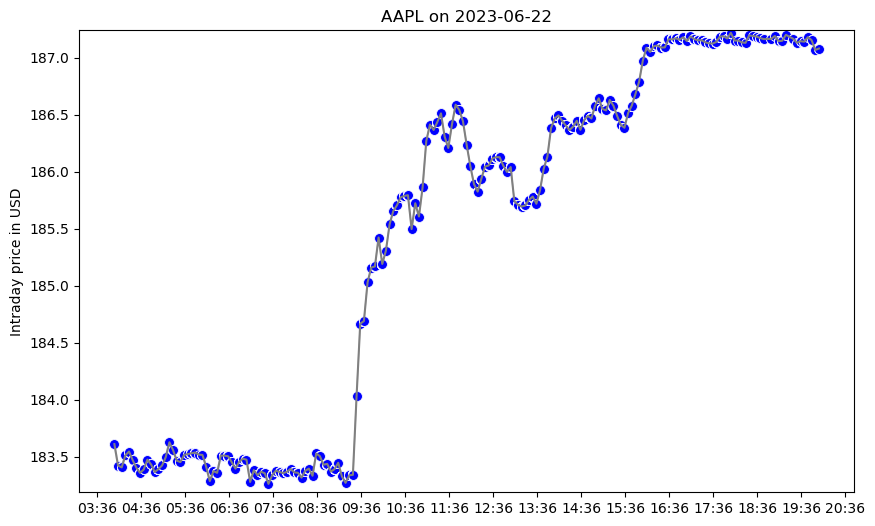

In [17]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the price series
sns.lineplot(x='dt', y='price', data=df_aapl, color='gray')

# Plot the aggregated price series
sns.scatterplot(x='dt', y='avg_price', data=df_aapl, color='blue', s=50)

# Set the x-axis label
plt.xlabel('')

# Set the y-axis label
plt.ylabel('Intraday price in USD')

# Set the y-axis limits
plt.ylim(df_aapl['price'].min(), df_aapl['price'].max())

# Set the x-axis major ticks to 60-minute intervals
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=60))

# Set the x-axis major tick labels to the format HH:MM
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set the title of the plot
plt.title(f'AAPL on {df_aapl["dt"].dt.date.unique()[0]}')

# Show the plot
plt.show()


Now let's scale up this project on KLC with __taq_project.py__.